In [1]:
!pip install -q datasets evaluate
!pip install fiftyone
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q regex tqdm
!pip install -q diffusers transformers accelerate scipy
!pip install -q -U xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.7/308.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 2.6 MB/s eta 0:00:

In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import os
import fiftyone as fo
import shutil
import pandas as pd
import cv2
import random
import hashlib
from PIL import Image
import albumentations as A
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from transformers import TFSegformerForSemanticSegmentation
from transformers import create_optimizer
import torch
import numpy as np
from diffusers.utils import load_image, make_image_grid
import torch
from torchvision.transforms.functional import to_pil_image
from PIL import Image
import cv2
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import copy
from diffusers import StableDiffusionInpaintPipeline, EulerDiscreteScheduler

/usr/local/lib/python3.12/dist-packages/glob2/fnmatch.py:141: SyntaxWarning: invalid escape sequence '\Z'
  return '(?ms)' + res + '\Z'


In [3]:
#H,W = 512,512
H,W = 256,256
BATCH_SIZE = 2
N_CLASSES = 24
LR = 5e-5
N_EPOCHS = 20
WEIGHT_DECAY_RATE = 0.01
MEAN = [123.675, 116.28, 103.53]
STD = [58.395, 57.12, 57.375]
### you can access the segformer model at ----->: https://drive.google.com/drive/folders/1w96WAlgJltjNAxN5jq5j9Q8w-_QGvTtR?usp=sharing
checkpoint_filepath = "/content/drive/MyDrive/fiftyone/segformer_b5_clothing.h5"

##Downloads

In [4]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d rajkumarl/people-clothing-segmentation

Dataset URL: https://www.kaggle.com/datasets/rajkumarl/people-clothing-segmentation
License(s): CC0-1.0
 99% 612M/616M [00:01<00:00, 286MB/s]
100% 616M/616M [00:01<00:00, 382MB/s]


In [5]:
!unzip "/content/people-clothing-segmentation.zip" -d "/content/dataset/"

Archive:  /content/people-clothing-segmentation.zip
  inflating: /content/dataset/jpeg_images/IMAGES/img_0001.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0002.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0003.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0004.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0005.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0006.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0007.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0008.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0009.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0010.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0011.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0012.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0013.jpeg  
  inflating: /content/dataset/jpeg_images/IMAGES/img_0014.jpeg  
  inflating: /content/dataset/jpeg_ima

In [6]:
im_path = "/content/dataset/png_images/IMAGES/"
anno_path = "/content/dataset/png_masks/MASKS/"
val_im_path = "/content/val_dataset/png_images/IMAGES/"
val_anno_path = "/content/val_dataset/png_masks/MASKS/"

In [7]:
for fname in os.listdir(anno_path):
  os.rename(anno_path+fname,anno_path+"img"+fname[3:])

#Split Data

In [8]:
!mkdir /content/val_dataset/
!mkdir /content/val_dataset/png_images/
!mkdir /content/val_dataset/png_masks/
!mkdir /content/val_dataset/png_images/IMAGES/
!mkdir /content/val_dataset/png_masks/MASKS/

In [9]:
val_list=["0115","0025","0010","0003","0125","0200","0515","0225","0805","0915","0630","0301","0112","0905","0823","0527","0088","0055","0018",
          "0222","0049","0273","0299","0282","0372","0027","0445","0582","0374","0956","0211","0019","0961","0397","0699","0789","0996","0290",
          "0110","0315","0335","0419","0666","0525","0927","0555","0275","0855","0815","0130","0371","0412","0105","0423","0507","0028","0035","0118",
          "0232","0849","0673","0688","0777","0472","0991","0485","0592","0334","0827","0651","0619","0567","0393","0609","0719","0916","0190",
          ]

In [10]:
for name in val_list:
  shutil.move(im_path+"img_"+name+".png", val_im_path+"img_"+name+".png")
  shutil.move(anno_path+"img_"+name+".png", val_anno_path+"img_"+name+".png")

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    ([im_path+i for i in os.listdir(im_path)],
    [anno_path+"img"+i[3:] for i in os.listdir(im_path)])
)
val_dataset = tf.data.Dataset.from_tensor_slices(
    ([val_im_path+i for i in os.listdir(val_im_path)],
    [val_anno_path+"img"+i[3:] for i in os.listdir(val_im_path)])
)

In [12]:
for i in train_dataset.take(3):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/png_images/IMAGES/img_0707.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/png_masks/MASKS/img_0707.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/png_images/IMAGES/img_0825.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/png_masks/MASKS/img_0825.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/png_images/IMAGES/img_0508.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/dataset/png_masks/MASKS/img_0508.png'>)


In [ ]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/content/val_dataset/png_images/IMAGES/img_0397.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/content/val_dataset/png_masks/MASKS/img_0397.png'>)


In [13]:
len(train_dataset)

923

In [14]:
len(val_dataset)

77

##Preprocessing

In [15]:
#Taken from IMAGENET in RGB format
MEAN = [123.675, 116.28, 103.53]
STD = [58.395, 57.12, 57.375]

In [16]:
def preprocess(im_path, anno_path):
  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.cast(img,tf.float32)
  img = (img-MEAN)/STD

  anno = tf.io.decode_jpeg(tf.io.read_file(anno_path))
  anno = tf.cast(tf.squeeze(anno,-1),tf.float32)

  return img, anno

In [17]:
prep_train_ds = (
    train_dataset
    .map(preprocess,num_parallel_calls=tf.data.AUTOTUNE)
)
prep_val_ds = (
    val_dataset
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
)

In [18]:
for i,j in prep_train_ds.take(1):
  print(i.shape,j.shape)

(825, 550, 3) (825, 550)


##Data Augmentation

In [19]:
H,W = 512,512
#H,W = 256,256

In [20]:
transform = A.Compose([
    A.RandomCrop (H,W, p=1.0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.RandomRotate90(p=0.3),
    A.Transpose(p=0.3),
    A.Sharpen (alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.1),
    A.RandomShadow (shadow_roi=(0, 0.5, 1, 1),
                    num_shadows_lower=1, num_shadows_upper=2,
                    shadow_dimension=5, p=0.1),
    A.RandomBrightnessContrast(p=0.2),
    #A.Resize(H,W),
])

val_transform = A.Compose([
    A.Resize(H,W),
])

/tmp/ipython-input-207722941.py:8: UserWarning: Argument(s) 'num_shadows_lower, num_shadows_upper' are not valid for transform RandomShadow
  A.RandomShadow (shadow_roi=(0, 0.5, 1, 1),


In [21]:
def aug_albument(image,mask):
  augmented = transform(image=image, mask=mask)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]
def val_aug_albument(image,mask):
  augmented = val_transform(image=image, mask=mask)
  return [tf.convert_to_tensor(augmented["image"],dtype=tf.float32),
          tf.convert_to_tensor(augmented["mask"], dtype=tf.float32)]

In [22]:
def augment(image,mask):
  aug_output = tf.numpy_function(func=aug_albument, inp=[image,mask], Tout=[tf.float32,tf.float32])
  return {"pixel_values":tf.transpose(aug_output[0],(2,0,1)), "labels":aug_output[1]}

def val_augment(image,mask):
  aug_output = tf.numpy_function(func=val_aug_albument, inp=[image,mask], Tout=[tf.float32,tf.float32])
  return {"pixel_values":tf.transpose(aug_output[0],(2,0,1)), "labels":aug_output[1]}

In [23]:
BATCH_SIZE = 1
train_ds = (
    prep_train_ds
    .shuffle(10)
    .map(augment,num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    prep_val_ds
    .map(val_augment,num_parallel_calls=tf.data.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
for i in train_ds.take(1):
  data = i

  print(i)

{'pixel_values': <tf.Tensor: shape=(2, 3, 512, 512), dtype=float32, numpy=
array([[[[ 2.060536  ,  2.060536  ,  2.0434113 , ...,  0.41655958,
           0.41655958,  0.41655958],
         [ 2.060536  ,  2.060536  ,  2.0434113 , ...,  0.38231006,
           0.38231006,  0.38231006],
         [ 2.060536  ,  2.060536  ,  2.0434113 , ...,  0.39943483,
           0.39943483,  0.39943483],
         ...,
         [ 2.0262864 ,  2.0262864 ,  2.0262864 , ..., -0.7136742 ,
          -0.6965494 , -0.66229993],
         [ 2.0262864 ,  2.0262864 ,  2.0262864 , ..., -0.7307989 ,
          -0.7136742 , -0.67942464],
         [ 2.0262864 ,  2.0262864 ,  2.0262864 , ..., -0.7307989 ,
          -0.7136742 , -0.67942464]],

        [[ 2.1834733 ,  2.1834733 ,  2.1659665 , ...,  0.8179272 ,
           0.8179272 ,  0.8179272 ],
         [ 2.1834733 ,  2.1834733 ,  2.1659665 , ...,  0.8529412 ,
           0.8529412 ,  0.8529412 ],
         [ 2.1834733 ,  2.1834733 ,  2.1659665 , ...,  0.87044823,
          

##Data Visualization

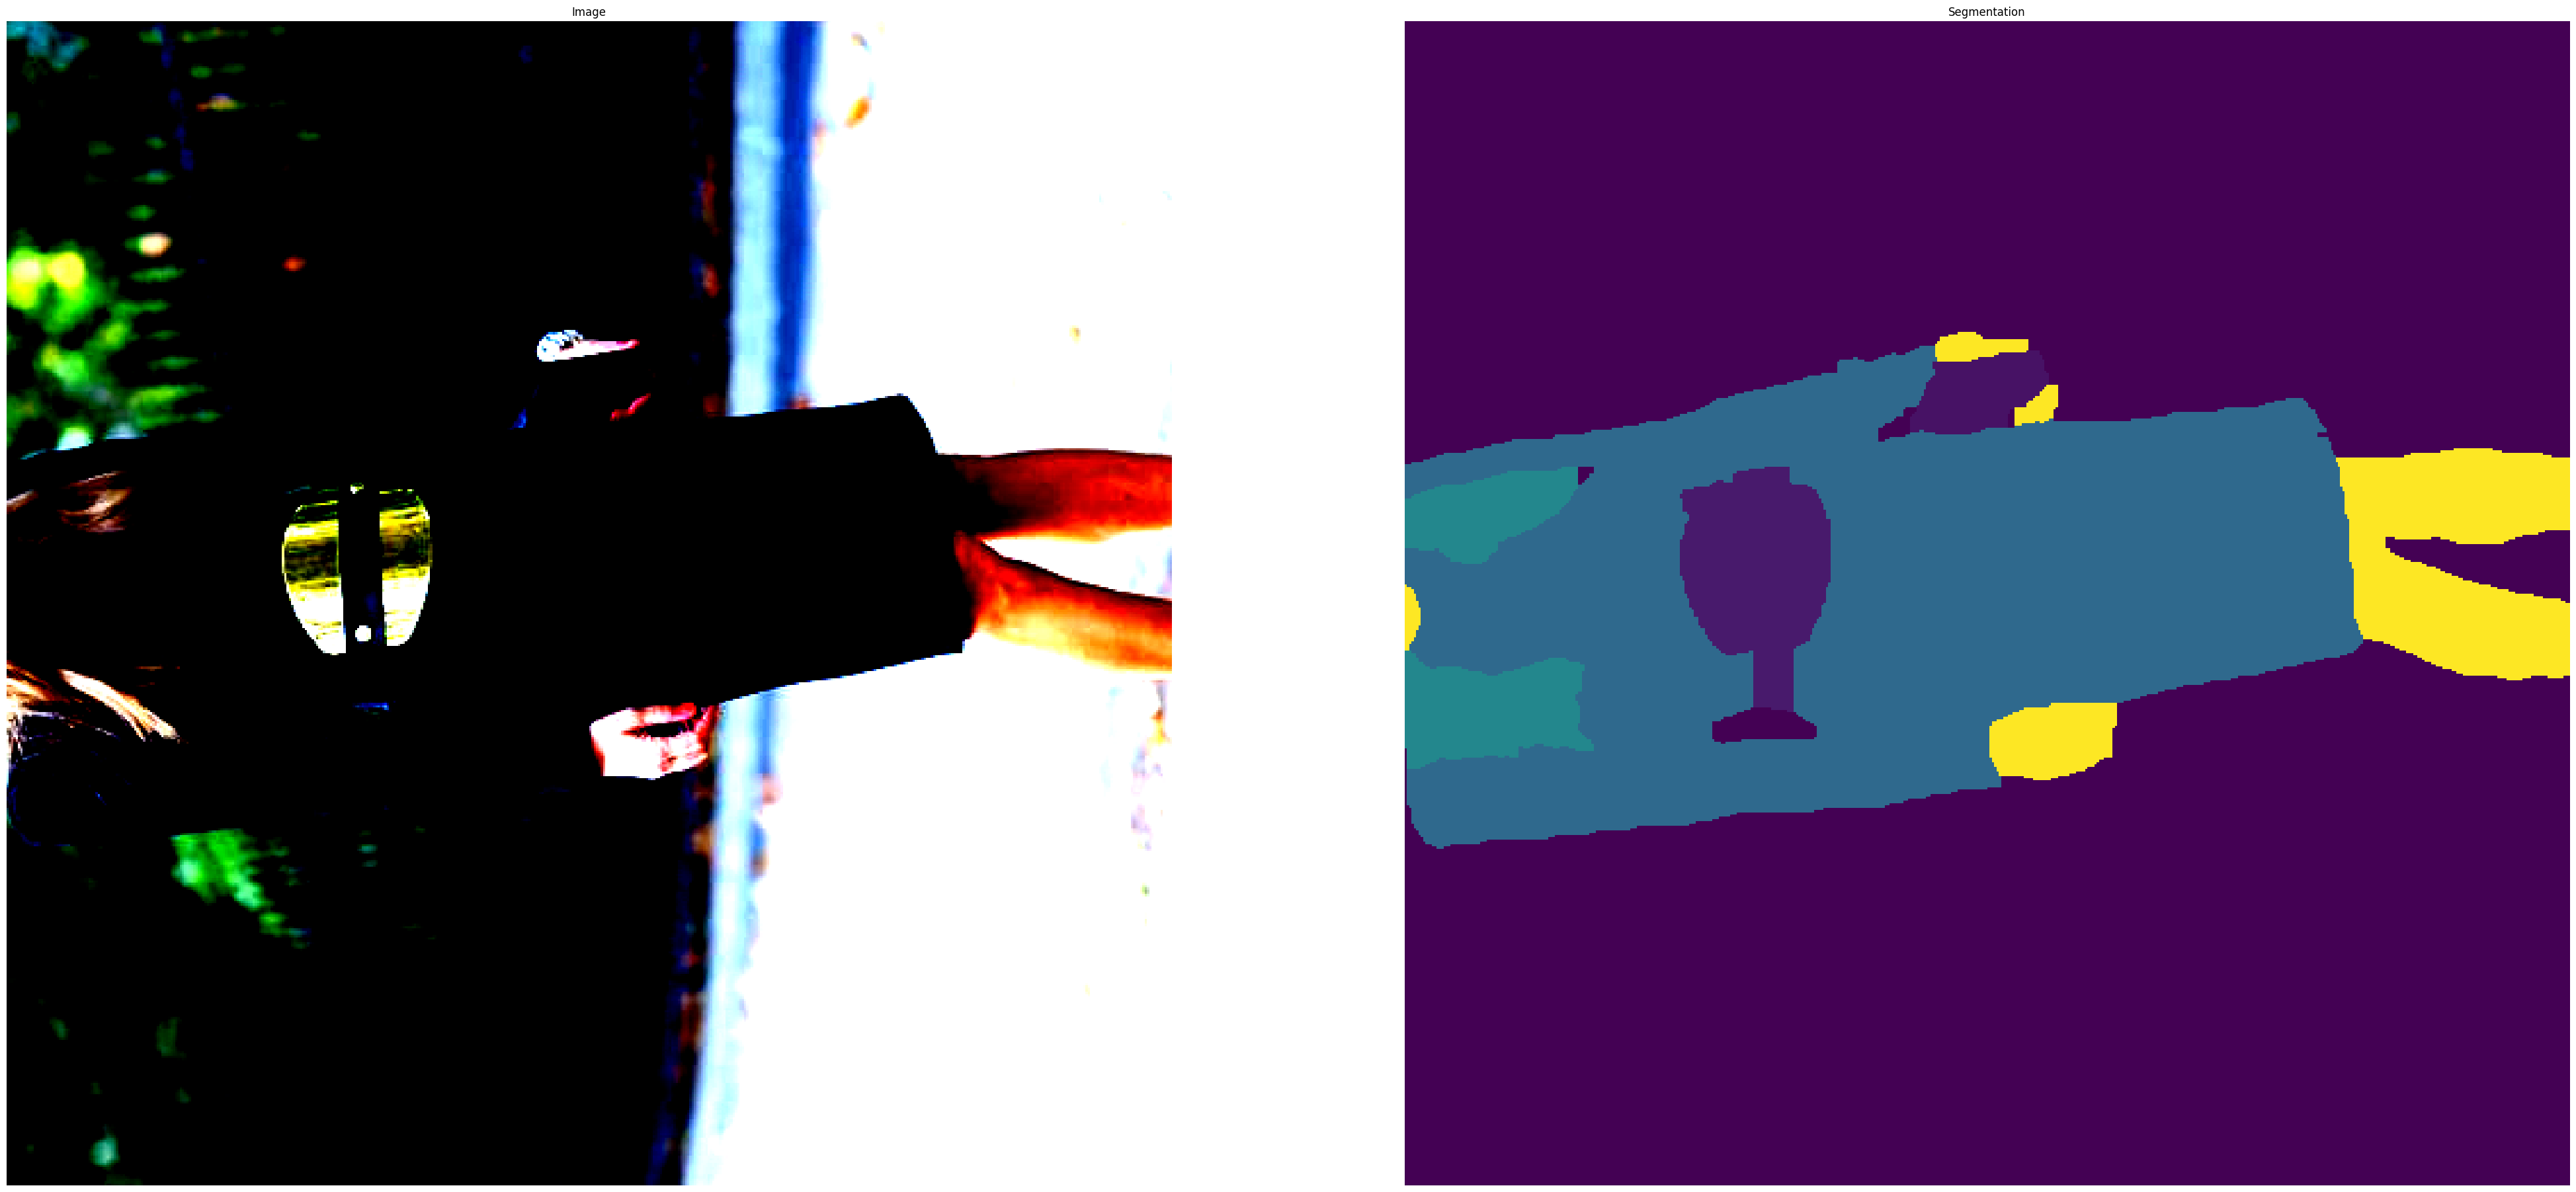

In [24]:
plt.figure(figsize = (50,50))

for data in train_ds.take(1):
  images=data['pixel_values']
  labels=data['labels']
  for i in range(BATCH_SIZE*2):
    if i==4:
      break
    ax = plt.subplot(1,BATCH_SIZE*2, i+1)
    if i%2==0:
      plt.imshow(tf.transpose(images[i//2], (1, 2, 0)))
      plt.title("Image")
    else:
      plt.imshow(labels[i//2])
      plt.title("Segmentation")
    plt.axis("off")
  plt.show()

##WOrking with Voxel51

In [25]:
name = "clothing-dataset-1"
data_path = "/content/val_dataset/png_images/IMAGES"
labels_path = "/content/val_dataset/png_masks/MASKS"
# Create the dataset
dataset = fo.Dataset.from_dir(
    data_path=data_path,
    labels_path=labels_path,
    dataset_type=fo.types.ImageSegmentationDirectory,
    name=name,
)

# View summary info about the dataset
print(dataset)

# Print the first few samples in the dataset
print(dataset.head())

You are running the oldest supported major version of MongoDB. Please refer to https://deprecation.voxel51.com for deprecation notices. You can suppress this exception by setting your `database_validation` config parameter to `False`. See https://docs.voxel51.com/user_guide/config.html#configuring-a-mongodb-connection for more information


 100% |███████████████████| 77/77 [77.8ms elapsed, 0s remaining, 989.3 samples/s]  


INFO:eta.core.utils: 100% |███████████████████| 77/77 [77.8ms elapsed, 0s remaining, 989.3 samples/s]  


Name:        clothing-dataset-1
Media type:  image
Num samples: 77
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Segmentation)
[<Sample: {
    'id': '68fb369ac7525e7f606d195c',
    'media_type': 'image',
    'filepath': '/content/val_dataset/png_images/IMAGES/img_0003.png',
    'tags': [],
    'metadata': None,
    'created_at': datetime.datetime(2025, 10, 24, 8, 19, 38, 143000),
    'last_modified_at': datetime.datetime(2025, 10, 24, 8, 19, 38, 143000),
    'ground_truth': <Segmentation: 

In [ ]:
session = fo.launch_app(dataset)


Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.9.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.9.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



In [ ]:
fo.close_app()

###Evaluation using fiftyone


In [ ]:
H_resized, W_resized = 512,512
H_init, W_init = 825,550
import evaluate
metric = evaluate.load("mean_iou")

In [ ]:
for i,sample in enumerate(dataset):

  img = tf.io.decode_jpeg(tf.io.read_file(sample.filepath))
  img = tf.image.resize(img, (H_resized, W_resized))
  img = tf.cast(img,tf.float32)
  img = (img-MEAN)/STD
  img = tf.transpose(img, (2,0,1))
  img = tf.expand_dims(img, axis=0)

  output = model(img).logits
  output = tf.argmax(output, axis=1)

  resized_output = tf.image.resize(
      tf.expand_dims(output,axis=-1),(H_init, W_init), method="bilinear", antialias=True)
  resized_output = tf.cast(tf.squeeze(resized_output, axis=-1),dtype=tf.uint8)[0]
  sample["pred"] = fo.Segmentation(mask=resized_output.numpy())

  mask = cv2.imread(sample["ground_truth"]["mask_path"], cv2.IMREAD_GRAYSCALE)
  metrics = metric.compute(
      predictions = [resized_output.numpy()],
      references = [mask],
      num_labels = len(label2id),
      ignore_index = 0,
      nan_to_num=0,
      reduce_labels=False
  )


  sample["mean_iou"] = metrics["mean_iou"]
  sample["mean_accuracy"] = metrics["mean_accuracy"]
  sample["overall_accuracy"] = metrics["overall_accuracy"]

  for k,c in enumerate(metrics["per_category_iou"]):
    if c>0.0001:
      key = id2label[k]+"_iou"### e.g. shoes_iou
      sample[key] = c

  sample.save()

In [47]:
dataset.default_mask_targets = id2label
session = fo.launch_app(dataset,port=51)


Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.9.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



INFO:fiftyone.core.session.session:
Welcome to

███████╗██╗███████╗████████╗██╗   ██╗ ██████╗ ███╗   ██╗███████╗
██╔════╝██║██╔════╝╚══██╔══╝╚██╗ ██╔╝██╔═══██╗████╗  ██║██╔════╝
█████╗  ██║█████╗     ██║    ╚████╔╝ ██║   ██║██╔██╗ ██║█████╗
██╔══╝  ██║██╔══╝     ██║     ╚██╔╝  ██║   ██║██║╚██╗██║██╔══╝
██║     ██║██║        ██║      ██║   ╚██████╔╝██║ ╚████║███████╗
╚═╝     ╚═╝╚═╝        ╚═╝      ╚═╝    ╚═════╝ ╚═╝  ╚═══╝╚══════╝ v1.9.0

If you're finding FiftyOne helpful, here's how you can get involved:

|
|  ⭐⭐⭐ Give the project a star on GitHub ⭐⭐⭐
|  https://github.com/voxel51/fiftyone
|
|  🚀🚀🚀 Join the FiftyOne Discord community 🚀🚀🚀
|  https://community.voxel51.com/
|



##Modeling

In [26]:
df = pd.read_csv("/content/dataset/labels.csv")

In [27]:
id2label = {}
for i,j in df.iterrows():
  if i==0:
    id2label[i] = 'nan'
  else:
    id2label[i] = j['label_list']

In [28]:
label2id = {label: id for id,label in id2label.items()}

In [29]:
print(label2id)
print(len(label2id))

{'nan': 0, 'accessories': 1, 'bag': 2, 'belt': 3, 'blazer': 4, 'blouse': 5, 'bodysuit': 6, 'boots': 7, 'bra': 8, 'bracelet': 9, 'cape': 10, 'cardigan': 11, 'clogs': 12, 'coat': 13, 'dress': 14, 'earrings': 15, 'flats': 16, 'glasses': 17, 'gloves': 18, 'hair': 19, 'hat': 20, 'heels': 21, 'hoodie': 22, 'intimate': 23, 'jacket': 24, 'jeans': 25, 'jumper': 26, 'leggings': 27, 'loafers': 28, 'necklace': 29, 'panties': 30, 'pants': 31, 'pumps': 32, 'purse': 33, 'ring': 34, 'romper': 35, 'sandals': 36, 'scarf': 37, 'shirt': 38, 'shoes': 39, 'shorts': 40, 'skin': 41, 'skirt': 42, 'sneakers': 43, 'socks': 44, 'stockings': 45, 'suit': 46, 'sunglasses': 47, 'sweater': 48, 'sweatshirt': 49, 'swimwear': 50, 't-shirt': 51, 'tie': 52, 'tights': 53, 'top': 54, 'vest': 55, 'wallet': 56, 'watch': 57, 'wedges': 58}
59


In [ ]:
#model_id = "nvidia/segformer-b5-finetuned-ade-640-640"
model_id = "nvidia/segformer-b1-finetuned-ade-512-512"
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_id,
    num_labels = len(label2id),
    id2label = id2label,
    label2id = label2id,
    ignore_mismatched_sizes = True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.
All model checkpoint layers were used when initializing TFSegformerForSemanticSegmentation.

Some weights of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b1-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head/classif

In [ ]:
model.summary()

Model: "tf_segformer_for_semantic_segmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segformer (TFSegformerMain  multiple                  13151424  
 Layer)                                                          
                                                                 
 decode_head (TFSegformerDe  multiple                  541499    
 codeHead)                                                       
                                                                 
Total params: 13692923 (52.23 MB)
Trainable params: 13692411 (52.23 MB)
Non-trainable params: 512 (2.00 KB)
_________________________________________________________________


In [ ]:
H,W = 256,256

In [ ]:
model(tf.zeros([1,3,H,W])).logits.shape

TensorShape([1, 59, 64, 64])

In [ ]:
model.load_weights(checkpoint_filepath)

##Training and Evaluation

In [ ]:
import evaluate
metric = evaluate.load("mean_iou")

In [ ]:
model(tf.zeros([1,3,H,W])).logits.shape

TensorShape([1, 59, 64, 64])

In [ ]:
def compute_metrics(eval_pred):
  logits, labels = eval_pred
  logits = tf.transpose(logits, perm=[0,2,3,1])
  logits_resized =tf.image.resize(
      logits,
      size=tf.shape(labels)[1:],
      method="bilinear"
  )
  pred_labels = tf.argmax(logits_resized, axis=-1)

  metrics = metric.compute(
      predictions = pred_labels,
      references = labels,
      num_labels = len(label2id),
      ignore_index = 0,
  )

  per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
  per_category_iou = metrics.pop("per_category_iou").tolist()

  metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
  metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

  return {"val_" + k: v for k, v in metrics.items()}

In [ ]:
batch_size = 1
num_epochs = 15
num_train_steps = len(train_ds) * num_epochs
learning_rate = 6e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_ds,
    batch_size=batch_size,
    label_cols=["labels"]
)
callbacks = [metric_callback]

In [ ]:
model.compile(optimizer=optimizer, run_eagerly=True)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    callbacks=callbacks,
)

Epoch 1/15
923/923 [==============================] - ETA: 0s - loss: 1.3286

/usr/local/lib/python3.12/dist-packages/datasets/features/image.py:357: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")


923/923 [==============================] - 676s 724ms/step - loss: 1.3286 - val_loss: 0.6470 - val_mean_iou: 0.0484 - val_mean_accuracy: 0.0910 - val_overall_accuracy: 0.3289 - val_accuracy_nan: nan - val_accuracy_accessories: 0.0000e+00 - val_accuracy_bag: 0.4314 - val_accuracy_belt: 0.0000e+00 - val_accuracy_blazer: 0.0043 - val_accuracy_blouse: 0.2466 - val_accuracy_bodysuit: 0.0000e+00 - val_accuracy_boots: 0.0000e+00 - val_accuracy_bra: nan - val_accuracy_bracelet: 0.0000e+00 - val_accuracy_cape: 0.0000e+00 - val_accuracy_cardigan: 0.0000e+00 - val_accuracy_clogs: nan - val_accuracy_coat: 0.6620 - val_accuracy_dress: 0.3004 - val_accuracy_earrings: nan - val_accuracy_flats: 0.0000e+00 - val_accuracy_glasses: 0.0000e+00 - val_accuracy_gloves: 0.0000e+00 - val_accuracy_hair: 0.5439 - val_accuracy_hat: 0.0000e+00 - val_accuracy_heels: 0.0000e+00 - val_accuracy_hoodie: nan - val_accuracy_intimate: nan - val_accuracy_jacket: 0.0971 - val_accuracy_jeans: 0.8180 - val_accuracy_jumper: 0.

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


923/923 [==============================] - 683s 740ms/step - loss: 0.8535 - val_loss: 0.5423 - val_mean_iou: 0.0770 - val_mean_accuracy: 0.1289 - val_overall_accuracy: 0.4332 - val_accuracy_nan: nan - val_accuracy_accessories: 0.0000e+00 - val_accuracy_bag: 0.5830 - val_accuracy_belt: 0.0000e+00 - val_accuracy_blazer: 0.0075 - val_accuracy_blouse: 0.1772 - val_accuracy_bodysuit: 0.0000e+00 - val_accuracy_boots: 0.0000e+00 - val_accuracy_bra: nan - val_accuracy_bracelet: 0.0000e+00 - val_accuracy_cape: 0.0000e+00 - val_accuracy_cardigan: 0.0000e+00 - val_accuracy_clogs: nan - val_accuracy_coat: 0.7829 - val_accuracy_dress: 0.5061 - val_accuracy_earrings: nan - val_accuracy_flats: 0.0000e+00 - val_accuracy_glasses: 0.0000e+00 - val_accuracy_gloves: 0.0000e+00 - val_accuracy_hair: 0.8649 - val_accuracy_hat: 0.0000e+00 - val_accuracy_heels: 0.0000e+00 - val_accuracy_hoodie: nan - val_accuracy_intimate: nan - val_accuracy_jacket: 0.1438 - val_accuracy_jeans: 0.8846 - val_accuracy_jumper: 0.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save_weights(checkpoint_filepath)

##Generating new samples

###Image Editing

In [ ]:
H_resized,W_resized = 512,512
H_init,W_init = 825,550

In [ ]:
def generate_inputs(im_path, mask_label):
  mask_id = label2id[mask_label]
  source_image = cv2.imread(im_path)

  img = tf.io.decode_jpeg(tf.io.read_file(im_path))
  img = tf.image.resize(img, (H_resized, W_resized))
  img = tf.cast(img, tf.float32)
  img = (img-MEAN)/STD
  img = tf.transpose(img, (2,0,1))
  img = tf.expand_dims(img, axis=0)

  output = model(img).logits

  output = tf.argmax(output, axis=1)

  resized_output = tf.image.resize(
      tf.expand_dims(output,axis=-1),(H_init, W_init), method="bilinear", antialias=True)
  resized_output = tf.cast(tf.squeeze(resized_output, axis=-1),dtype=tf.uint8)[0].numpy()
  mask = resized_output.astype(np.int16) + (-mask_id*np.ones_like(resized_output, dtype=np.int16))

  mask = 255-np.clip(1e10*np.multiply(mask,mask),a_min=0, a_max=255)
  cv2.imwrite("mask.jpg", mask.astype(np.uint8))

  return Image.fromarray(source_image), Image.fromarray(mask.astype(np.uint8))

In [ ]:
generate_inputs("/content/val_dataset/png_images/IMAGES/img_0003.png","shoes")

(<PIL.Image.Image image mode=RGB size=550x825>,
 <PIL.Image.Image image mode=L size=550x825>)

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    dtype=torch.float16,
)
pipe.to("cuda")
pipe.enable_xformers_memory_efficient_attention()

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionInpaintPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

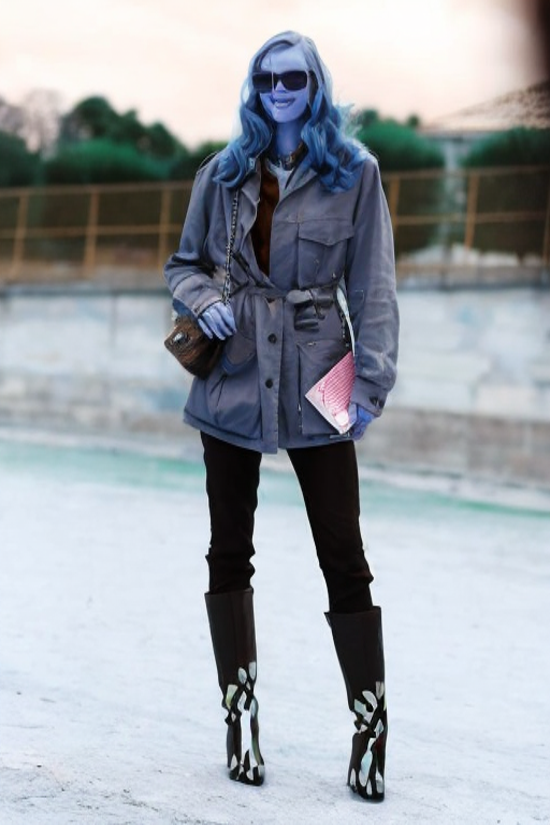

In [ ]:
prompt = "The women with white-coloured shoes, high resolution"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image, mask_image = generate_inputs(
    "/content/val_dataset/png_images/IMAGES/img_0003.png","shoes")

image = pipe(prompt=prompt, image=image, mask_image=mask_image, ).images[0]
image.resize((W_init, H_init))
display(image.resize((550,825)))

## New Data Augmentation

In [30]:
model_id = "stabilityai/stable-diffusion-2-inpainting"

In [31]:
def create_pipeline(model_id):
  scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
  pipe = StableDiffusionInpaintPipeline.from_pretrained(model_id,
                                                        scheduler=scheduler,
                                                        revision="fp16",
                                                        torch_dtype=torch.float16)

  pipe = pipe.to("cuda")
  pipe.enable_xformers_memory_efficient_attention()
  return pipe

In [32]:
pipeline = create_pipeline(model_id)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:333: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2-inpainting via `revision='fp16'`. This behavior is deprecated and will be removed in diffusers v1. One should use `variant='fp16'` instead. However, it appears that stabilityai/stable-diffusion-2-inpainting currently does not have the required variant filenames in the 'main' branch. 
 The Diffusers team and community would be very grateful if you could open an issue: https://github.com/huggingface/diffusers/issues/new with the title 'stabilityai/stable-diffusion-2-inpainting is missing fp16 files' so that the correct variant file can be added.
  warnings.warn(


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/635 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
`torch_dtype` is deprecated! Use `dtype` instead!
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--stabilityai--stable-diffusion-2-inpainting/snapshots/76eb2c8bdc2cbaf387603cbae34884c254a05e80/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error inste

In [43]:
from torchvision import transforms
def generate_inputs(im_path,mask_path, mask_id):
  #source_image = cv2.imread(im_path)
  source_image = Image.open(im_path)
  source_image = source_image.convert("RGB")
  sd_mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)

  out = (sd_mask.astype(np.int16)+(-mask_id*np.ones_like(sd_mask, dtype=np.int16)))
  mask=-(np.clip(1e10*np.multiply(out,out),a_min=0,a_max=255)-255)
  cv2.imwrite("mask.jpg", mask)
  pil_image = source_image.resize((512,512))
  pil_mask = Image.fromarray(mask).resize((512,512))

  return pil_image, pil_mask

In [34]:
def augpaint(pipe, prompt, pil_image, pil_mask, guidance_scale, num_inference_steps):

  num_images_per_prompt = 1
  generator = torch.Generator(device="cuda").manual_seed(10)

  encoded_images = []

  for i in range(num_images_per_prompt):
    image = pipe(prompt=prompt, guidance_scale=guidance_scale,
                  num_inference_steps=num_inference_steps, generator=generator,
                  image=pil_image, mask_image=pil_mask, strength=0.99).images[0]



    encoded_images.append(image.resize((550,825)))
  return encoded_images[0]

In [35]:
def create_hash():
  randint = random.randint(0, 100000000)
  hash = hashlib.sha256(str(randint).encode("utf-8")).hexdigest()[:10]
  return hash

In [36]:
def list_classes(mask_path):

  mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE)
  list_unique = np.unique(mask)
  return list_unique

In [37]:
guidance_scale = 8
num_inference_steps = 25


val_im_path = "/content/val_dataset/png_images/IMAGES/"
val_anno_path = "/content/val_dataset/png_masks/MASKS/"

In [46]:
dataset.head()

[<Sample: {
     'id': '68fb369ac7525e7f606d195c',
     'media_type': 'image',
     'filepath': '/content/val_dataset/png_images/IMAGES/img_0003.png',
     'tags': [],
     'metadata': None,
     'created_at': datetime.datetime(2025, 10, 24, 8, 19, 38, 143000),
     'last_modified_at': datetime.datetime(2025, 10, 24, 8, 19, 38, 143000),
     'ground_truth': <Segmentation: {
         'id': '68fb369ac7525e7f606d195b',
         'tags': [],
         'mask': None,
         'mask_path': '/content/val_dataset/png_masks/MASKS/img_0003.png',
     }>,
 }>,
 <Sample: {
     'id': '68fb369ac7525e7f606d1965',
     'media_type': 'image',
     'filepath': '/content/val_dataset/png_images/IMAGES/img_0010.png',
     'tags': [],
     'metadata': None,
     'created_at': datetime.datetime(2025, 10, 24, 8, 19, 38, 150000),
     'last_modified_at': datetime.datetime(2025, 10, 24, 8, 19, 38, 150000),
     'ground_truth': <Segmentation: {
         'id': '68fb369ac7525e7f606d195d',
         'tags': [],
      

In [39]:
def transform_sample(sample, select_class, prompt):
  hash = create_hash()
  filename = sample.filepath.split("/")[-1][:-4]+"_"+str(hash)+".png"
  pipe = pipeline

  im,mask = generate_inputs(
      sample.filepath, sample.ground_truth.mask_path,
      label2id[select_class])

  out = augpaint(pipe, prompt, im, mask, guidance_scale, num_inference_steps)

  #cv2.imwrite(sample.filepath[:-4]+"_"+str(hash)+".png",
   #           np.array(out))
  im_saved = out.save(sample.filepath[:-4]+"_"+str(hash)+".png")

  shutil.copy(sample.ground_truth.mask_path,
              sample.ground_truth.mask_path[:-4]+"_"+str(hash)+".png",
              )

  display(out)

  new_sample = fo.Sample(
    filepath=sample.filepath[:-4]+"_"+str(hash)+".png",
    ground_truth=fo.Segmentation(
        mask_path=sample.ground_truth.mask_path[:-4]+"_"+str(hash)+".png"),
  )

  return new_sample

  0%|          | 0/24 [00:00<?, ?it/s]

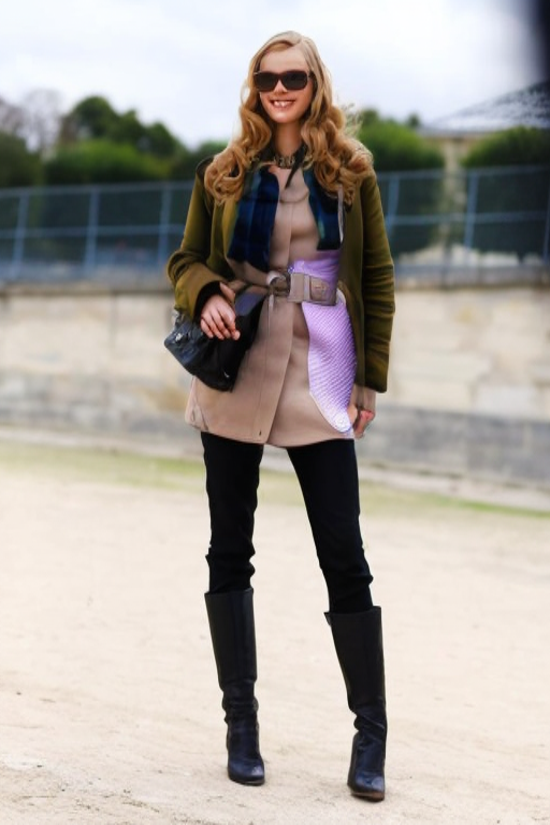

In [45]:
for sample in dataset:
  new_sample = transform_sample(sample, "coat", "A photorealistic photo of a woman wearing a green-colored nice looking coat all green  high resolution")
  dataset.add_sample(new_sample)
  break

  0%|          | 0/24 [00:00<?, ?it/s]

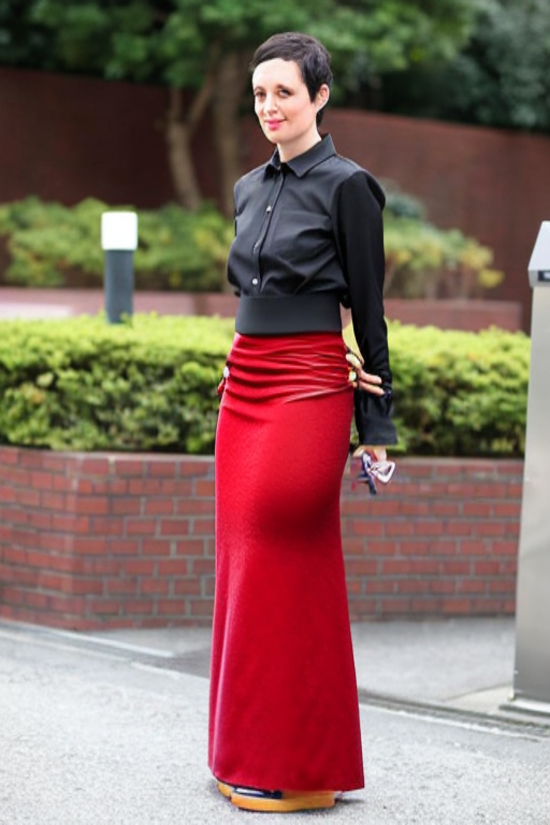

In [49]:
for sample in dataset:
  if sample.id == '68fb369ac7525e7f606d1966':
    new_sample = transform_sample(sample, "skirt", "A photorealistic photo of a woman wearing a red-colored nice looking skirt all red  high resolution")
    dataset.add_sample(new_sample)
  #break